In [109]:
#!pip install yfinance 
#!pip install talib-binary
#!pip install monthly_returns_heatmap 

In [110]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import timedelta

import yfinance as yf
import talib as ta
import monthly_returns_heatmap 

In [111]:
# define the variable parameters
ticker = 'AMZN'
start_date = '2019-01-01'
end_date = '2022-3-18'

**1) Getting the Price Data**

In [112]:
# Fetch the adjusted price data
# auto_adjust: Set this to True to download the adjusted price. By default, it is False.

data = yf.download(ticker, start_date, end_date, auto_adjust=True)

# Display the data
data.head()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Volume
Date,,,,,
2019-01-02,1465.199951,1553.359985,1460.930054,1539.130005,7983100
2019-01-03,1520.010010,1538.000000,1497.109985,1500.280029,6975600
2019-01-04,1530.000000,1594.000000,1518.310059,1575.390015,9182600
2019-01-07,1602.310059,1634.560059,1589.189941,1629.510010,7993200
2019-01-08,1664.689941,1676.609985,1616.609985,1656.579956,8881400


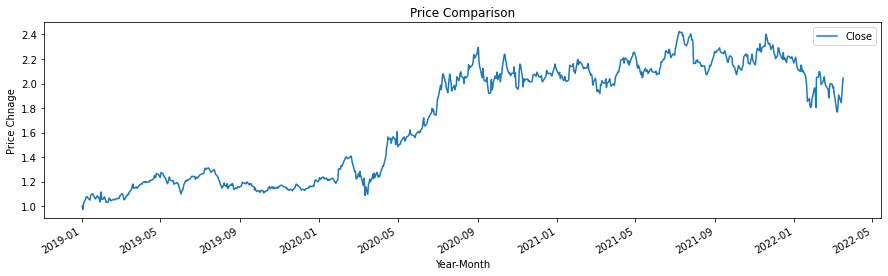

In [113]:
# Plot the absolute price series
plt.figure(figsize=(15,4))
(data['Close']/data['Close'].iloc[0]).plot()

# Set the title and axes label
plt.title('Price Comparison', fontsize=12)
plt.xlabel('Year-Month', fontsize=10)
plt.ylabel('Price Chnage', fontsize=10)
plt.legend()
plt.show()

**2) Examining the MACD Indicator - Potential Entry/ Exits**

In [114]:
# Calculate the MACD line, signal line and MACD histogram
data['macd_line'], \
data['macd_signal_line'], \
data['macd_hist'] = ta.MACD(data['Close'])

# Drop the NaN values
data.dropna(inplace=True)

In [115]:
# Generate buy signals
# Use 1 for buy and 0 for no action
data['macd_signal'] = np.where(data['macd_line'] > data['macd_signal_line'], 1, 0)

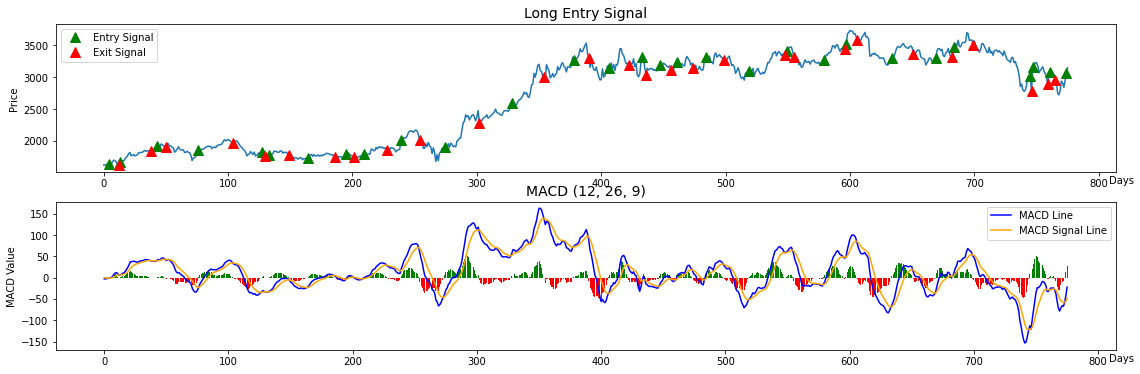

In [116]:
# Show the potential entry/ exit points based on historic timeframe defined for the ticker(s)
data_for_plot = data[start_date:end_date]
num_of_x_values = data_for_plot['Close'].shape[0]

# Define the plot figure
fig = plt.figure(figsize=(19, 6))

# Sub plot for the close price and entry signal
ax1 = fig.add_subplot(211)

# Set the title and axis labels
ax1.set_title('Long Entry Signal', fontsize=14)

# set xlabel to end of graph
ax1.set_xlabel('Days', fontsize=10)
ax1.xaxis.set_label_coords(1.005, -0.025) 
ax1.set_ylabel('Price', fontsize=10)

# Plot close price, using adjusted price, which takes into consideration of stock splits/ merge
ax1.plot(range(num_of_x_values), data_for_plot['Close'])

# Plot long entry points
entry_condition_to_plot = np.where((data_for_plot['macd_signal'] == 1) & (data_for_plot['macd_signal'].shift(1) == 0),
                                   data_for_plot['Close'], np.nan)

ax1.plot(range(num_of_x_values), entry_condition_to_plot, '^', ms=10, label='Entry Signal', color='green')
ax1.legend()

# Plot exit points
entry_condition_to_plot = np.where((data_for_plot['macd_signal'] == 0) & (data_for_plot['macd_signal'].shift(1) == 1),
                                   data_for_plot['Close'], np.nan)

ax1.plot(range(num_of_x_values), entry_condition_to_plot, '^', ms=10, label='Exit Signal', color='red')
ax1.legend()

# Sub plot for the MACD line, signal line and MACD histogram
ax2 = fig.add_subplot(212)
ax2.set_title(('MACD (12, 26, 9)'), fontsize=14)

# set xlabel to end of graph
ax2.set_xlabel('Days', fontsize=10)
ax2.xaxis.set_label_coords(1.005, -0.025)
ax2.set_ylabel('MACD Value', fontsize=10)

# Plot the MACD line and signal line
ax2.plot(range(num_of_x_values), data_for_plot['macd_line'], label='MACD Line', color='blue')
ax2.plot(range(num_of_x_values), data_for_plot['macd_signal_line'], label='MACD Signal Line', color='orange')

# Colour of the MACD histogram
macd_hist_colour = ['green' if (x > 0) else 'red' for x in data_for_plot.macd_hist]

# Plot MACD histogram
ax2.bar(range(num_of_x_values), data_for_plot['macd_hist'], color=macd_hist_colour)
ax2.legend()
plt.show()

**3) Defining Exit Strategy** <br>
A long position is closed if any of the following condition is met.

1) MACD line crosses below signal line <br>
2) Stop loss/ Profit target met (risk/ reward ratio at 1:3) <br>
3) Exit timing (e.g. >30 days) <br>

PNL = entry price - exit price + 2*transaction cost/ slippage (e.g. broker assign price slightly below your buy/ ask price, factor of 2 because this is a round trip cost)


In [117]:
# Transaction cost
# Feel free to change the transaction cost to a value that suits your local market and broker
txn_cost = 0.0002
slippage = 0.0005

# Calculate the PnL
def long_exit(price, time, entry_time, entry_price):
    pnl = round(price.loc[time, 'Close'] - entry_price, 2)
    # Calculate the trading cost and slippage, assuming costs are round trip in nature
    trade_txn = price.loc[time, 'Close'] * txn_cost * 2
    trade_slippage = price.loc[time, 'Close'] * slippage * 2
    trading_cost = trade_txn + trade_slippage
    # Calculate the PnL
    pnl = pnl - trading_cost
    return pd.DataFrame([(entry_time, entry_price, time, price.loc[time, 'Close'], pnl)])

def get_trade_book(price, signal_col, take_profit_target, stop_loss_target):
    # Define the current position and other variables
    current_position = 0
    stop_loss = ''
    take_profit = ''
    entry_time = np.nan
    entry_price = np.nan
    trades = pd.DataFrame()

    # Loop to check the entry and exit logic on each data point
    for time in price.index:
        # Long entry point
        if (current_position == 0) and (price.loc[time, signal_col] == 1):
            current_position = 1
            entry_time = time
            entry_price = price.loc[time, 'Close']

            # Stop loss as a percentage of entry price
            stop_loss = entry_price * (1-stop_loss_target)

            # Profit target as a percentage of entry price
            take_profit = entry_price * (1+take_profit_target)

        # Close the open position based on stop loss and profit target
        elif current_position == 1:
            # Check for stop loss and profit target
            if price.loc[time, 'Close'] < stop_loss or price.loc[time, 'Close'] > take_profit:
                trade_details = long_exit(price, time, entry_time, entry_price)
                trades = trades.append(trade_details, ignore_index=True)
                current_position = 0

        # Close any open position after holding for a month
            if (time-entry_time) >= timedelta(days=30):
                trade_details = long_exit(price, time, entry_time, entry_price)
                trades = trades.append(trade_details, ignore_index=True)
                current_position = 0

    trades.columns = ['Entry Time', 'Entry Price', 'Exit Time', 'Exit Price', 'PNL']
    return trades

**4) Return the Initial Simulated PNL**

In [118]:
# with 1:3 risk/ reward ratio
trade_book_MACD = get_trade_book(data, 'macd_signal', 0.06, 0.02) 
trade_book_MACD.head()

,Entry Time,Entry Price,Exit Time,Exit Price,PNL
0,2019-02-26,1636.400024,2019-03-18,1742.150024,103.310990
1,2019-03-19,1761.849976,2019-04-18,1861.689941,97.233634
2,2019-04-23,1923.770020,2019-05-13,1822.680054,-103.641752
3,2019-06-10,1860.630005,2019-07-09,1988.300049,124.886380
4,2019-07-10,2017.410034,2019-07-19,1964.520020,-55.640328


In [119]:
# show trades made and total simulated PNL
print('Total trades made:', trade_book_MACD['PNL'].count())
print('Total Profit/ Loss:', trade_book_MACD['PNL'].sum().round(2))

Total trades made: 51
Total Profit/ Loss: 44.12


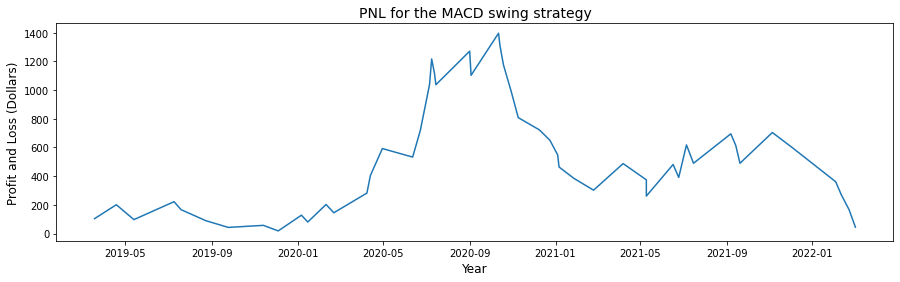

In [122]:
# Define the figure size for the plot
plt.figure(figsize=(15, 4))

# Define the label for the title of the figure
plt.title('PNL for the MACD swing strategy', fontsize=14)

# Define the labels for x-axis and y-axis
plt.xlabel('Year', fontsize=12)
plt.ylabel('Profit and Loss (Dollars)', fontsize=12)

# Plot the PnL
plt.plot(trade_book_MACD['Exit Time'], trade_book_MACD.PNL.cumsum())

plt.show()

**5) Perform Back Testing**

In [123]:
def backtesting_details(trade_book, price_data):
    backtesting_det = pd.DataFrame(index=['Backtesting Strategy'])

    # Number of trades
    backtesting_det['Number of Trades'] = trade_book.shape[0]

    # Startegy start date
    backtesting_det['Strategy Start Date'] = price_data.index[0]

    # Strategy end date
    backtesting_det['Strategy End Date'] = price_data.index[-1]

    # Duration in months
    backtesting_det['Duration'] = "{} months".format(
        (backtesting_det['Strategy End Date'].iloc[0].year -
         backtesting_det['Strategy Start Date'].iloc[0].year) * 12 +
        (backtesting_det['Strategy End Date'].iloc[0].month -
         backtesting_det['Strategy Start Date'].iloc[0].month))

    # Holding time
    trade_book['Holding Time'] = trade_book['Exit Time'] - trade_book['Entry Time']
    backtesting_det['Average holding time'] = trade_book['Holding Time'].mean()
    backtesting_det['Median holding time'] = trade_book['Holding Time'].median()
    backtesting_det['Minimum holding time'] = trade_book['Holding Time'].min()
    backtesting_det['Maximum holding time'] = trade_book['Holding Time'].max()

    display(backtesting_det.astype(object).T)
backtesting_details(trade_book_MACD, data)

,Backtesting Strategy
Number of Trades,51
Strategy Start Date,2019-02-20 00:00:00
Strategy End Date,2022-03-17 00:00:00
Duration,37 months
Average holding time,12 days 00:00:00
Median holding time,9 days 00:00:00
Minimum holding time,1 days 00:00:00
Maximum holding time,32 days 00:00:00


**6) Plotting the Back Testing Returns**

<Figure size 864x288 with 0 Axes>

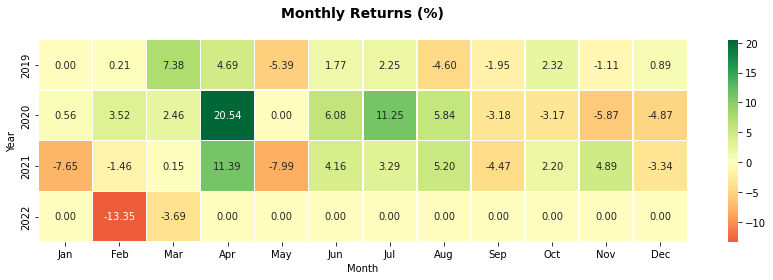

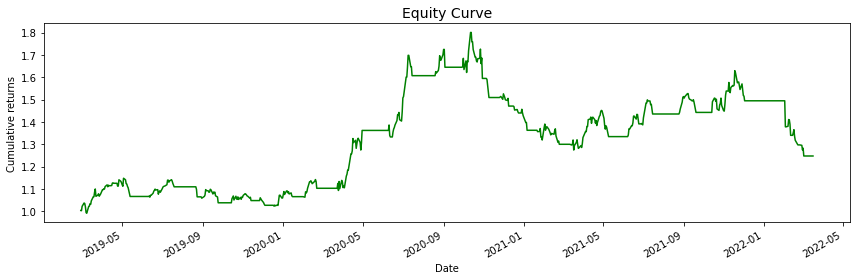

,Returns Metric
Cumulative Return,24.72
Annualised Return,452.39
Profit Factor,1.05
Win Rate,38.00


In [128]:
def return_metric(trade_book, price_data):
    import monthly_returns_heatmap as mrh

    return_metrics = pd.DataFrame(index=['Returns Metric'])

    # Add the positions to the price_data based on the trade book
    price_data['positions'] = np.nan
    price_data.loc[list(trade_book['Entry Time']), 'positions'] = 1
    price_data.loc[list(trade_book['Exit Time']), 'positions'] = 0
    price_data['positions'].ffill(inplace=True)

    # Add the PNL column based on the trade book
    price_data['PNL'] = 0
    price_data.loc[list(trade_book['Entry Time']), 'PNL'] = trade_book['PNL'].values

    # Calculate the strategy returns
    price_data['strategy_returns'] = price_data['positions'].shift(1) * price_data['Close'].pct_change()

    # Calculate the cumulative returns
    price_data['cumulative_returns'] = (1+price_data['strategy_returns']).cumprod()
    return_metrics['Cumulative Return'] = (price_data['cumulative_returns'][-1] - 1)*100

    # Calculate the annualized returns
    return_metrics['Annualised Return'] = ((1+price_data['cumulative_returns'][-1]) **(252*6.5/price_data.shape[0]) - 1) * 100

    # Calculate profit factor
    sum_of_profit = price_data[price_data['PNL'] > 0]['PNL'].sum().round(3)
    sum_of_loss = -price_data[price_data['PNL'] < 0]['PNL'].sum().round(3)
    return_metrics['Profit Factor'] = (sum_of_profit / sum_of_loss).round(3)

    # Calculate Win/Loss Ratio
    count_of_profit = price_data[price_data['PNL'] > 0]['PNL'].count()
    count_of_loss = price_data[price_data['PNL'] < 0]['PNL'].count()
    return_metrics['Win Rate'] = (count_of_profit / (count_of_profit+count_of_loss) * 100).round(3)

    # Heatmap of month vs year returns
    fig = plt.figure(figsize=(12, 4))
    mrh.plot(price_data['strategy_returns'], figsize=(12,4))
    plt.tight_layout()
    plt.show()

    # Plot cumulative strategy returns
    price_data['cumulative_returns'].plot(figsize=(12, 4), color='green')
    plt.title('Equity Curve', fontsize=14)
    plt.ylabel('Cumulative returns')
    plt.tight_layout()
    plt.show()

    display(return_metrics.round(2).T)
return_metric(trade_book_MACD, data)

**7) Establishing the Risk Matrix**

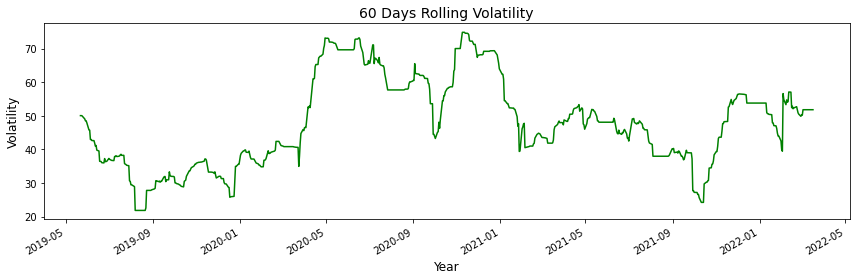

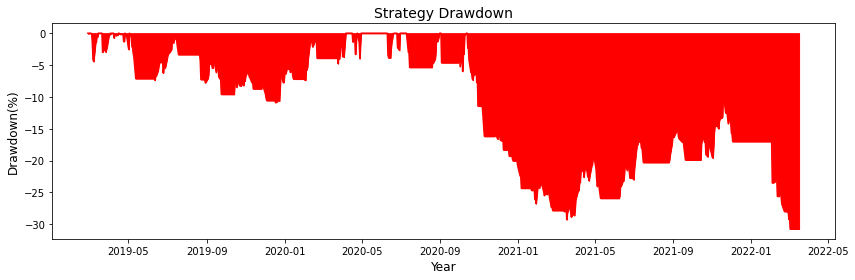

,Risk Metric
Annualised Volatility,49.93%
Maximum Drawdown,-30.74%


In [131]:
def risk_metric(trade_book, price_data):

    risk_metrics = pd.DataFrame(index=['Risk Metric'])

    # Add the positions to the price_data based on the trade book
    price_data['positions'] = np.nan
    price_data.loc[list(trade_book['Entry Time']), 'positions'] = 1
    price_data.loc[list(trade_book['Exit Time']), 'positions'] = 0
    price_data['positions'].ffill(inplace=True)

    # Calculate the strategy returns
    price_data['strategy_returns'] = price_data['positions'].shift(1) * \
                                     price_data['Close'].pct_change()

    # Calculate the cumulative returns
    price_data['cumulative_returns'] = (1+price_data['strategy_returns']).cumprod()

    risk_metrics['Annualised Volatility'] = "{0:.2f}%".format(
        price_data['strategy_returns'].std()*np.sqrt(252*6.5) * 100)

    # 60 days Rolling estimation of volatility
    window_size = 60
    price_data['rolling_volatility'] = price_data['strategy_returns'].rolling(window_size).std() * np.sqrt(252*6.5) * 100
    price_data['rolling_volatility'].plot(figsize=(12,4), color='green')
    plt.title('60 Days Rolling Volatility', fontsize=14)
    plt.xlabel('Year', fontsize=12)
    plt.ylabel('Volatility', fontsize=12)
    plt.tight_layout()
    plt.show()

    # ---------------------Max drawdown---------------------
    # Calculate the running maximum
    running_max = np.maximum.accumulate(price_data['cumulative_returns'].dropna())
    # Ensure the value never drops below 1
    running_max[running_max < 1] = 1
    # Calculate the percentage drawdown
    drawdown = ((price_data['cumulative_returns'])/running_max - 1) * 100

    # Calculate the maximum drawdown
    risk_metrics['Maximum Drawdown'] = "{0:.2f}%".format(drawdown.min())

    # Plotting the drawdowns
    fig = plt.figure(figsize=(12, 4))

    # Plot max drawdown
    plt.plot(drawdown, color='red')
    plt.figsize=(12,4)
    # Fill in-between the drawdown
    plt.fill_between(drawdown.index, drawdown.values, color='red')
    plt.title('Strategy Drawdown', fontsize=14)
    plt.ylabel('Drawdown(%)', fontsize=12)
    plt.xlabel('Year', fontsize=12)

    plt.tight_layout()
    plt.show()

    display(risk_metrics.round(2).T)

risk_metric(trade_book_MACD, data)

In [132]:
def risk_adjusted_return_metric(trade_book, price_data):

    risk_adjusted_return_metrics = pd.DataFrame(index=['Risk Adjusted Returns Metric'])

    # ---------------------Positions---------------------
    # Add the positions to the price_data based on the trade book
    price_data['positions'] = np.nan
    price_data.loc[list(trade_book['Entry Time']), 'positions'] = 1
    price_data.loc[list(trade_book['Exit Time']), 'positions'] = 0
    price_data['positions'].ffill(inplace=True)

    # ---------------------Startegy returns---------------------
    # Calculate the strategy returns
    price_data['strategy_returns'] = price_data['positions'].shift(1) * \
                                     price_data['Close'].pct_change()

    # ---------------------Cumulative returns---------------------
    # Calculate the cumulative returns
    price_data['cumulative_returns'] = (1 + price_data['strategy_returns']).cumprod()

    # ---------------------Sharpe ratio---------------------
    # assuming risk-free rate = 0
    risk_adjusted_return_metrics['Sharpe ratio'] = round(price_data['strategy_returns'].mean()/
                   price_data['strategy_returns'].std() * np.sqrt(252*6.5), 2)

    # ---------------------Sortino ratio---------------------
    # assuming risk-free rate = 0
    std_neg = price_data['strategy_returns'][price_data['strategy_returns'] < 0].std()
    risk_adjusted_return_metrics['Sortino ratio'] = round(price_data['strategy_returns'].mean()/
                    std_neg * np.sqrt(252*7), 2)

    # ---------------------Calmar ratio---------------------
    # Annualised return
    annualised_return = ((1 + price_data['cumulative_returns'][-1]) **
                         (252*7/price_data.shape[0]) - 1)
    # Max drawdown
    # Calculate the running maximum
    running_max = np.maximum.accumulate(price_data['cumulative_returns'].dropna())
    # Ensure the value never drops below 1
    running_max[running_max < 1] = 1
    # Calculate the percentage drawdown
    drawdown = price_data['cumulative_returns']/running_max - 1

    # Calculate the maximum drawdown
    max_dd = drawdown.min()
    # assuming risk-free rate = 0
    risk_adjusted_return_metrics['Calmar ratio'] = round(annualised_return/abs(max_dd), 2)

    display(risk_adjusted_return_metrics.astype(object).T)


risk_adjusted_return_metric(trade_book_MACD, data)

,Risk Adjusted Returns Metric
Sharpe ratio,1.19
Sortino ratio,1.32
Calmar ratio,17.24


In [133]:
# creating a function to analyse the performance of the strategy
def analyse_performance(trade_book, price_data):
    """
    Analyse the performance of the strategy.
    """
    # Call backtesting_details
    backtesting_details(trade_book, price_data)
    # Call return_metric
    return_metric(trade_book, price_data)
    # Call risk_metric
    risk_metric(trade_book, price_data)
    # Call risk_adjusted_return_metric
    risk_adjusted_return_metric(trade_book, price_data)